# Constants

In [33]:
NUMBER_OF_PROCESSORS = 20
CLUSTERS_WIDTH = 2
WATER_IDS = [['B', 1, ' OW '], ['C', 1, ' OW ']]
FIRST_ATOMS_TO_IGNORE = 0

# Imports

In [34]:
from PELETools import ControlFileParser as cfp
from PELETools import SimulationParser as sp
from ReportMetrics import Metrics
from sklearn import cluster
from multiprocessing import Pool
import statistics
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from copy import copy

# Functions

In [35]:
def obtain_water_data_from(control_file_path):
    print('- Parsing control file...')
    builder = cfp.ControlFileBuilder(control_file_path)
    cf = builder.build()
    sim = cf.getSimulation()
    
    print('- Listing reports...')
    list_of_reports = []
    for report in sim.iterateOverReports:
        list_of_reports.append(report)
    
    print('- Retrieving data...')
    with Pool(NUMBER_OF_PROCESSORS) as pool:
        atom_data = pool.map(parallel_atom_getter, list_of_reports)
    
    fixed_atom_data = []
    
    print('- Linking report pointers...')
    for (path, name), atom_coords in atom_data:
        for report in list_of_reports:
            if ((report.path, report.name) == (path, name)):
                report_pointer_to_add = report
                break
        else:
            raise NameError("Report {}{} not found".format(path, name))
        fixed_atom_data.append((report_pointer_to_add, atom_coords))
    
    print('- Parsing data...')
    return split_atom_data(fixed_atom_data), list_of_reports

In [36]:
def parallel_atom_getter(report):
    atom_coords = {}
    for i, water_id in enumerate(WATER_IDS):
        atoms = report.trajectory.getAtoms(water_id)
        for j, atom in enumerate(atoms[FIRST_ATOMS_TO_IGNORE:]):
            atom_coords[(i, j + FIRST_ATOMS_TO_IGNORE)] = atom.coords
    
    atom_data = ((report.path, report.name), atom_coords)
    return atom_data

In [37]:
def split_atom_data(atom_data):
    atom_reports = []
    atom_ids = []
    atom_models = []
    atom_coords = []

    for data in atom_data:
        for (water_id, model), coords in data[1].items():
            atom_reports.append(data[0])
            atom_ids.append(water_id)
            atom_models.append(model)
            atom_coords.append(coords)

    return atom_reports, atom_ids, atom_models, atom_coords

In [38]:
def get_density(atom_ids, results):
    n_clusters = int(max(results) + 1)
    
    # Initialize density dictionary
    density = {}
    for iteration_id in range(0, n_clusters):
        density[iteration_id] = 0

    for water_id in range(0, len(WATER_IDS)):
        for i, atom_id in enumerate(atom_ids):
            if (atom_id == water_id):
                density[results[i]] += 1
                
    # Normalize
    norm_factor = 1 / (len(results) / len(WATER_IDS))

    for iteration_id in range(0, n_clusters):
        density[iteration_id] *= norm_factor
                
    return density

In [39]:
def get_metric(list_of_reports, col_num=None, metric_name=None):
    if (col_num is None and metric_name is None):
        raise NameError("Either column number or metric name must be especified")

    # Get metrics
    metric_values = []
    
    for report in list_of_reports:
        metric_values += report.getMetric(col_num, metric_name)[FIRST_ATOMS_TO_IGNORE:]
    
    return metric_values

In [40]:
def get_ordered_matchs(list_of_reports, matchs_dict, reference_matchs, min_matchs_tofulfill=None):
    matchs = []
    
    for report in list_of_reports:
        for match in sorted(matchs_dict[report].values()):
            matchs.append(fulfill_condition(match, reference_matchs, min_matchs_tofulfill))
    
    return matchs

In [41]:
def get_matchs(results, list_of_reports, atom_reports, atom_models):
    matchs = {}

    # Initialize matchs_dict
    for report in list_of_reports:
        matchs[report] = {}
        for model in range(FIRST_ATOMS_TO_IGNORE, report.trajectory.models.number):
            matchs[report][model] = []
         
    for i, cluster_id in enumerate(results):
        matchs[atom_reports[i]][atom_models[i]].append(cluster_id)
    
    return matchs

In [42]:
def fulfill_condition(matchs, reference_matchs, min_matchs_to_fulfill=None):
    if (min_matchs_to_fulfill is None):
        min_matchs_to_fulfill = len(reference_matchs)
        
    copied_reference_matchs = copy(reference_matchs)
    common_matchs = []
    
    for match in matchs:
        if match in copied_reference_matchs:
            copied_reference_matchs.remove(match)
            common_matchs.append(match)
    
    return len(common_matchs)

In [43]:
def write_centroids(estimator, densities=None, output_name='centroid.pdb', normalize=False):
    # Writer functions
    def single_write(f, i, centroid, density=None):
        f.write("ATOM    {:3d}  CEN BOX A   1 {:>11.3f}{:>8.3f}{:>8.3f}  1.00  0.00\n".format(i, *centroid))
    def density_write(f, i, centroid, density):
        f.write("ATOM    {:3d}  CEN BOX A   1 {:>11.3f}{:>8.3f}{:>8.3f}  1.00{:>5.2f}\n".format(i, *centroid, density))
    
    # Get centroids and number of clusters
    centroids = estimator.cluster_centers_
    n_clusters = len(centroids)

    # Select writer function
    writer = single_write
    if (densities is not None):
        if (len(densities) == len(centroids)):
            writer = density_write
    
    # Normalize
    norm_densities = densities
    if (normalize):
        if (densities):
            normalization_factor = 1 / max(densities.values())
            norm_densities = []
            for density in densities.values():
                norm_densities.append(density * normalization_factor)

    # Write centroids to PDB
    n_clusters = len(centroids)
    with open(output_name, 'w') as f:
        for i, centroid in enumerate(centroids):
            writer(f, i, centroid, norm_densities[i])

#  Bromodomain

## Read Simulation data and extract water info

In [44]:
CONTROL_FILE_PATH = '/home/municoy/LocalResults/waters/4STD/with_water/adaptive.conf'
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = obtain_water_data_from(CONTROL_FILE_PATH)

- Parsing control file...
  - A total of 50 epochs and 6350 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Retrieve reference data

In [45]:
reference = sp.Trajectory('4STD_original.pdb', '/home/municoy/LocalResults/waters/4STD/with_water/PDB/', None, 0, 0, 0)
ref_coords = []
for water_id in WATER_IDS:
    ref_coords.append(reference.getAtoms(water_id)[0].coords)

## Clustering

In [46]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

In [47]:
reference_clusters = []
for ref_coord in ref_coords:
    reference_clusters += estimator.predict([ref_coord]).tolist()

In [48]:
print(reference_clusters)

[2, 5]


## Clustering analysis

In [49]:
densities = get_density(atom_ids, results)

In [50]:
# matchs_dict is dict will have atom_report + atom_model as key and number of matchs as value
matchs_dict = get_matchs(results, list_of_reports, atom_reports, atom_models)

In [51]:
for report, matchs_per_model in matchs_dict.items():
    report_metrics = [0, ] * FIRST_ATOMS_TO_IGNORE
    for (model, matchs) in sorted(matchs_per_model.items()) :
        report_metrics.append(fulfill_condition(matchs, reference_clusters))

    report.addMetric('waterMatchs', report_metrics)        

## Display results

In [52]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
        0        0.328
        1        0.269
 *      2        0.330
        3        0.233
        4        0.199
 *      5        0.086
        6        0.083
        7        0.138
        8        0.044
        9        0.050
       10        0.033
       11        0.031
       12        0.061
       13        0.020
       14        0.025
       15        0.020
       16        0.004
       17        0.017
       18        0.002
       19        0.002
       20        0.001
       21        0.021
       22        0.003


In [53]:
write_centroids(estimator, densities, '/home/municoy/LocalResults/waters/4STD/with_water/PDB/4STD_centroids.pdb', normalize=False)

In [54]:
total_energy = get_metric(list_of_reports, metric_name='currentEnergy')
energies = get_metric(list_of_reports, metric_name='Binding Energy')
distances = get_metric(list_of_reports, metric_name='Lig-Asn123_distance')
matchs = get_ordered_matchs(list_of_reports, matchs_dict, reference_clusters)
norm = plt.Normalize(0, len(WATER_IDS))
cmap = plt.cm.RdYlGn
patches_list = [patches.Patch(color=cmap(norm(0)), label='No matches'), ]
for i in range(len(WATER_IDS)):
    if i == 0:
        match_str = "match"
    else:
        match_str = "matches"
    patches_list.append(patches.Patch(color=cmap(norm(i + 1)), label='{} {}'.format(i + 1, match_str)))

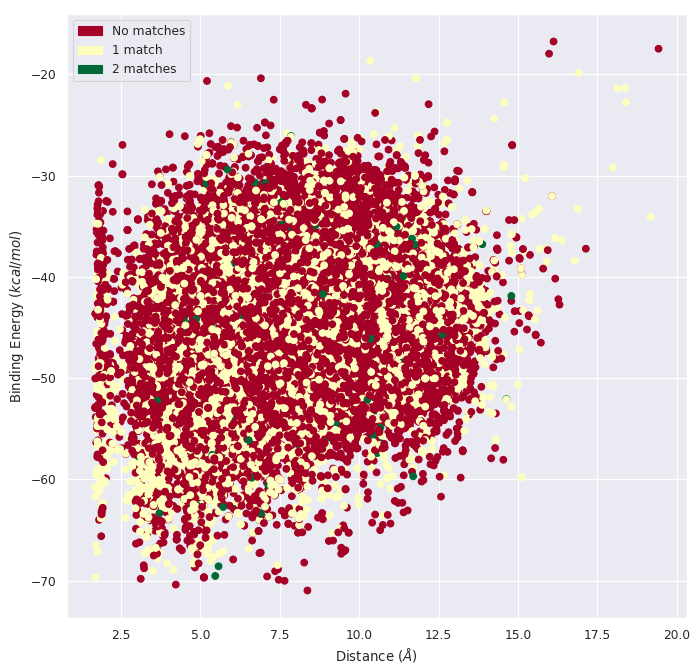

In [55]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, energies, c=matchs, cmap=cmap, norm=norm)
ax.legend(handles=patches_list)
plt.show()

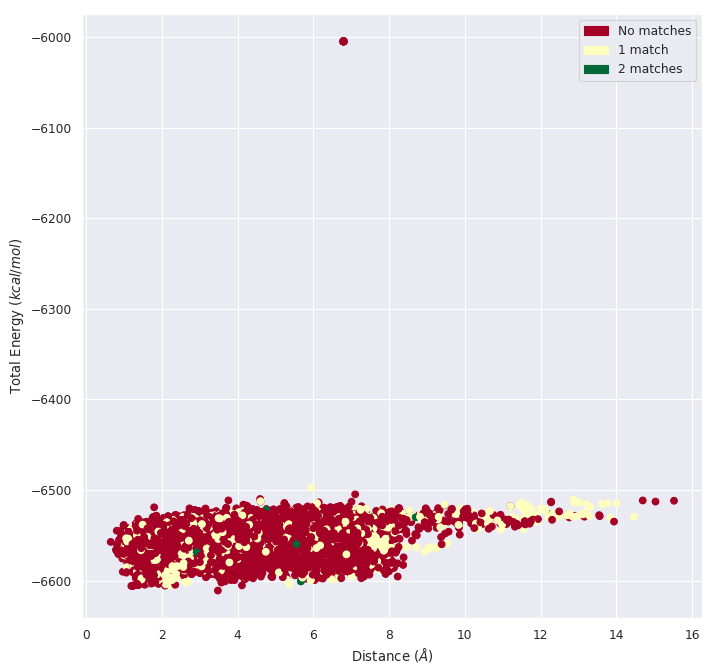

In [32]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Total Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, total_energy, c=matchs, cmap=cmap, norm=norm)
ax.legend(handles=patches_list)
plt.show()

# TODO
- Add distance metric